### General Overview
-When doing research on syntopic weather systems, it is important to see their virtical structure by taking crossections with respesct to height levels. The purpose of this notebook is to explore a method to scan an area by vertical cross sections and to either draw a plot or returning a video (Essentially generated by [Matplotlib.FuncAnimation()](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html)).

-Packages involved: xarray, matplotlib, cartopy, numpy, and metpy.\
-Other than one interactive function, the notebook has all parameters for function set up to run. However, there were tons of work done for standardization, so feel free to change the variable you want to look at after you walk through this notebook. 

In [14]:
import xarray as xr, matplotlib.pyplot as plt, numpy as np, metpy as mp, matplotlib.animation as animation
import metpy.calc as mpcalc
from metpy.interpolate import cross_section, geodesic
from metpy.units import units
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import datetime
from matplotlib import cm
from matplotlib import cbook
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
from PIL import Image
from IPython import display
from functools import partial

The data we use here is from [ERA5 dataset](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=form). Theoretically, the data can generate crossections from any dataset retrieved from ERA5 dataset as long as the variables in the dataset includes temperature and geopotential height. 

-At first, we need to read the data by xarray function.\
-Because the default names in the dataset is too long, we should change some variables/coordinate's name at first.\
 (You don't need to do this step at all if you are comfortable with the default!)\
-Because we don't have potential temperatures in the raw dataset, we need to calculate them by metpy function ([mpcalc.potential_temperature()](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.potential_temperature.html)).

In [15]:
ds=xr.open_dataset('./data/12z.grib', engine='cfgrib')
ds=ds.metpy.quantify()
ds=ds.rename({"isobaricInhPa":"pressure","latitude":"lat", "longitude":"lon"})
 #You need to process some data at first before puting it into function
ds['thta']=mpcalc.potential_temperature(ds.pressure, ds.t) #We don't have thta at beginning 
ds['z']=ds.z/9.8 #To calculate geopotential height, the value need to be devided by $g$

#Take a look with the processed dataset!
ds

<xarray.Dataset>
Dimensions:     (time: 4, pressure: 27, lat: 201, lon: 321)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2022-09-11 ... 2022-09-11T18:00:00
    step        timedelta64[ns] 00:00:00
  * pressure    (pressure) float64 1e+03 975.0 950.0 925.0 ... 150.0 125.0 100.0
  * lat         (lat) float64 70.0 69.75 69.5 69.25 ... 20.75 20.5 20.25 20.0
  * lon         (lon) float64 -130.0 -129.8 -129.5 -129.2 ... -50.5 -50.25 -50.0
    valid_time  (time) datetime64[ns] 2022-09-11 ... 2022-09-11T18:00:00
Data variables:
    z           (time, pressure, lat, lon) float32 <Quantity([[[[   69.59622 ...
    t           (time, pressure, lat, lon) float32 <Quantity([[[[276.1101  27...
    u           (time, pressure, lat, lon) float32 <Quantity([[[[ -7.872925  ...
    v           (time, pressure, lat, lon) float32 <Quantity([[[[-3.51583862e...
    w           (time, pressure, lat, lon) float32 <Quantity([[[[-2.76851654e...
    vo          (time, pressure, lat, lon) float32 <Quantity([[[[ 3.62282153e...
    thta        (pressure, time, lat, lon) float64 <Quantity([[[[276.11010742...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-01-23T16:31 GRIB to CDM+CF via cfgrib-0.9.1...

There are many occasions that we only need to look at a small area do out research and draw crossections, so the following ```selection()``` function is defined. \
-The function acts as a specified version of [.sel()](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.sel.html?highlight=.sel()#xarray.Dataset.sel) function in xarray

What you can specify in this function:\
-Only the veriables you want for later use.\
-Area of the interest\
-Pressure level of interest (Only one level at a time! Essential for the initial map, but please don't specify when doing crossection!)\
-The index value of time you want (Only one at a time!)

In [16]:
def selection(dataset,  vrbs, extent=None, plevel=None, tidx=None):
    r'''
    Parameters
    ----------
    dataset: 'xarray.Dataset' 
        The dataset imported before.
    vrbs: 'list'
        Variables want to keep in the new xarray dataset. Should be a list of names consistent with the name of variable in the xarray.Dataset (Or what resutns by doing list(dataset.keys())).
        Example:['t', 'z', 'w']
    extent=None: 'list'
        Should be 2 pairs of lat, lon values in a least, use the dataset's span in lat&lon if not specified.
        (Example: [-130,-60,20, 52] (This is a CONUS view!))
    plevel:'int'
        The pressure level want to keep in the new dataset.
        (One level only)
    tidx:'int'
        Time index in the old dataset that you want to keep in the new dataset.
        (One time only)
    
    Returns
    -------
    'xarray.Dataset'
        The filtered dataset. 
    '''
    if extent==None:
        extent=[dataset.lon.values[0], dataset.lon.values[-1], dataset.lat.values[-1], dataset.lat.values[0]]
    if plevel!=None:
        temp=dataset[vrbs]
        dataset=temp.sel(pressure=plevel, lat=slice(extent[3], extent[2]), lon=slice(extent[0], extent[1]))
    else: 
        temp=dataset[vrbs]
        dataset=temp.sel(lat=slice(extent[3], extent[2]), lon=slice(extent[0], extent[1]))
    if tidx==None:
        return dataset
    else:
        return dataset.isel(time=tidx)

Since we haven't have our points for cross sections defined, we need to prepare a dataset on some pressure level to identify our area of interest. Hence, we need to slice out some data in one pressure level to generates maps in later functions.\
<b>-Note: Certainly, we can't make cross section for a dataset that only in one pressure level, so we will call ```selection()``` at a later time!</b> 

In [4]:
ds1=selection(ds, ['z', 'thta', 'vo'], extent=[-130,-60,20, 52], plevel=500, tidx=0)
ds1

Magnitude,[[5811.23974609375 5812.08154296875 5813.025390625 ... 5834.9130859375 5833.6884765625 5832.15771484375] [5814.708984375 5815.47412109375 5816.3671875 ... 5835.27001953125 5833.7138671875 5831.8515625] [5817.642578125 5818.40771484375 5819.22412109375 ... 5835.04052734375 5833.05078125 5830.93359375] ... [5870.88232421875 5870.29541015625 5869.60693359375 ... 5928.12744140625 5928.2548828125 5928.33154296875] [5870.83154296875 5870.27001953125 5869.65771484375 ... 5927.94873046875 5927.99951171875 5928.1015625] [5870.7548828125 5870.24462890625 5869.708984375 ... 5927.74462890625 5927.8212890625 5927.92333984375]]
Units,meter2/second2
Magnitude,[[317.8683011129455 317.8766342140973 317.88615775827077 ... 322.8348293994114 322.86101914588846 322.8193536401295] [317.900443074531 317.9123475047478 317.9373468082032 ... 323.0074436375556 323.00506275151224 322.945540600428] [317.9349659221598 317.9599652256152 317.9992498453308 ... 323.2026762931118 323.18601009080817 323.11220262346376] ... [331.40363826949323 331.32387858704044 331.204834284872 ... 325.60618075389186 325.61689474108704 325.6145138550437] [331.4631604205774 331.37268675092946 331.250071119696 ... 325.7585574606674 325.75141480253734 325.7180823979302] [331.52149212864 331.4262566869052 331.3036410556718 ... 325.9037915093129 325.86212600355395 325.77760454901437]]
Units,kelvin
Magnitude,[[-9.539513848721981e-05 -9.834556840360165e-05 -0.000101146986708045 ... -8.180527947843075e-05 -6.136088632047176e-05 -3.0068447813391685e-05] [-9.521632455289364e-05 -9.625940583646297e-05 -9.754090569913387e-05 ... -8.767633698880672e-05 -6.359606049954891e-05 -2.4107983335852623e-05] [-9.60805919021368e-05 -9.539513848721981e-05 -9.41732432693243e-05 ... -8.299737237393856e-05 -5.680113099515438e-05 -1.1740019544959068e-05] ... [-2.9233982786536217e-05 -3.155856393277645e-05 -3.111152909696102e-05 ... -2.5925925001502037e-05 -2.2111227735877037e-05 -1.7402460798621178e-05] [-2.7773668989539146e-05 -3.066449426114559e-05 -3.0187657102942467e-05 ... -2.190261147916317e-05 -1.6091158613562584e-05 -1.2455275282263756e-05] [-2.6909401640295982e-05 -2.9561808332800865e-05 -2.9621412977576256e-05 ... -1.7164042219519615e-05 -1.2395670637488365e-05 -1.1382391676306725e-05]]
Units,1/second


The next step is to confirm the coordinate that we wnat to do the scanning.

However, before introducing the function, I need to introduce the parameters for setting the plotting parameters at first. \
-All the specifing parameters for plotting in any plot-related functions below should be typed in a dictionary at first.

The following is an example dictionary:

In [17]:
###Example!
plotfile={'contour':{
                 'thta':{'level': np.arange(250, 450, 3),
                         'color':'red',
                         'linewidths':1,
                         'title':"Potential temperature (K)"},
                    'z':{'level': np.arange(0, 10000, 60),
                         'color':'black',
                         'linewidths':1, 
                         'title': "Geopotential height (m)"},
                    't':{'level': np.arange(0, 400, 3),
                         'color':'black',
                         'linewidths':1, 
                         'title': "Temperature (K)"}},
             'fill':{
                   'vo':{'level': np.arange(5e-5,40e-5,5e-5),
                         'cmap':plt.cm.YlOrRd,
                         'title': "Relative vorticity(1/s)"},
                    'w':{'level': np.arange(-3, 3.1, 0.5),
                         'cmap':plt.cm.PuOr,
                         'title': "Omega(Pa/s)"}}}
  

As you can see, there are in total of 3 layers in this dictionary. A picture for explaining dictionary structure is mentioned in the README file, 
but I am also putting one here for quick reference.

<img src='plotfile.png' width='360' height='240'/>

Please feel free to change the plotfile dictionary file of you want to plot some other parameters, but it has to be in the following format:\
If it is a contour, attach the following to ```'contour'```:
```python 
   'variable name':#Your variable name in the dataset
             {
             'level': #Your contour interval, should be a numpy array
             'color': #Your contour color, should be a string with full name of color (It will be written on the title!)
             'linewidth': #How wide you want your line is. should be in int type
             'title': #Your variable's official name with a unit (Named as title because it is mainly used in title
             }
```
If it is a filled contour, attach the following to ```'fill'```:
```python 
   'variable name': #Your variable name in the dataset
            { 
             'level': #Your contour interval, should be a numpy array
             'cmap': #Your colormap, should be the name of the colorbar after plt.cm
             'title': #Your variable's official name with a unit (Named as title because it is mainly used in title
             }
```
Here is [a link for colormaps in matplotlib](https://matplotlib.org/stable/gallery/color/colormap_reference.html)

It doesn't need to be perfect match for the name of variable to do the plotting--The plotting fuction actually only runs when the <b>same variable name</b> is in both the dataset and the plotfile dictionary here.

Now it's the time to explain the fuction ```estimation(dataset, pos1=[None, None], pos2=[None, None], pos3=[None, None], plotfile=plotfile)```. \
This function is an interactive fuction for generating coordinate for the scanner. What you must put is a dataset with lat/lon or latitude/longitude as x&y axis and a plotfile for plotting parameters. Initially, no metter have you decided your coordinates yet or not for the scanner, a base map is drawn for you to see what happens on the lat&lon surface. Lat and lon are given by ticks for adding convienence. 

At the beginning, if you have your coordinates decided you can just put each pair of them in the location you want(It can also run if you have't decided one of the locations yet)

Note, each of the pos# slot corresponds to following:\
-<font color='red'>pos1(Show later as red dot)</font>: Initial point of first cross section\
-<font color='orange'>pos2(Show later as orange dot)</font>: Final point of first cross section\
-<font color='teal'>pos3(Show later as teal dot)</font>: First point of last cross section 


If you want to fix your coordinate, type something other than <b>y</b> or <b>Y</b> (This is case insensitve!!!).\
Your new input should be numbers typed like following "lat1, lon1, lat2, lon2, lat3, lon3" (compatible for both float and int, mainly requireing each number seperated by commas, no worries on the spaces)

However, if you just want to change only one parameter, you can always type <b>None or something else for the rest of part</b>.\
If you want to leave by whatever reason, just type <b>y</b> or <b>Y</b>.

<b>A test lat/lon pairs is given here:</b> 34, -100, 45, -105, 41, -85 

<b>Remember you need to put the dataset and plotfile before you run the function! (For here as I have everything set up already so you can ignore)\
    And, you can assign an variable in front of the function to store the output! (I also let the function print the coords out so not necessary).</b>

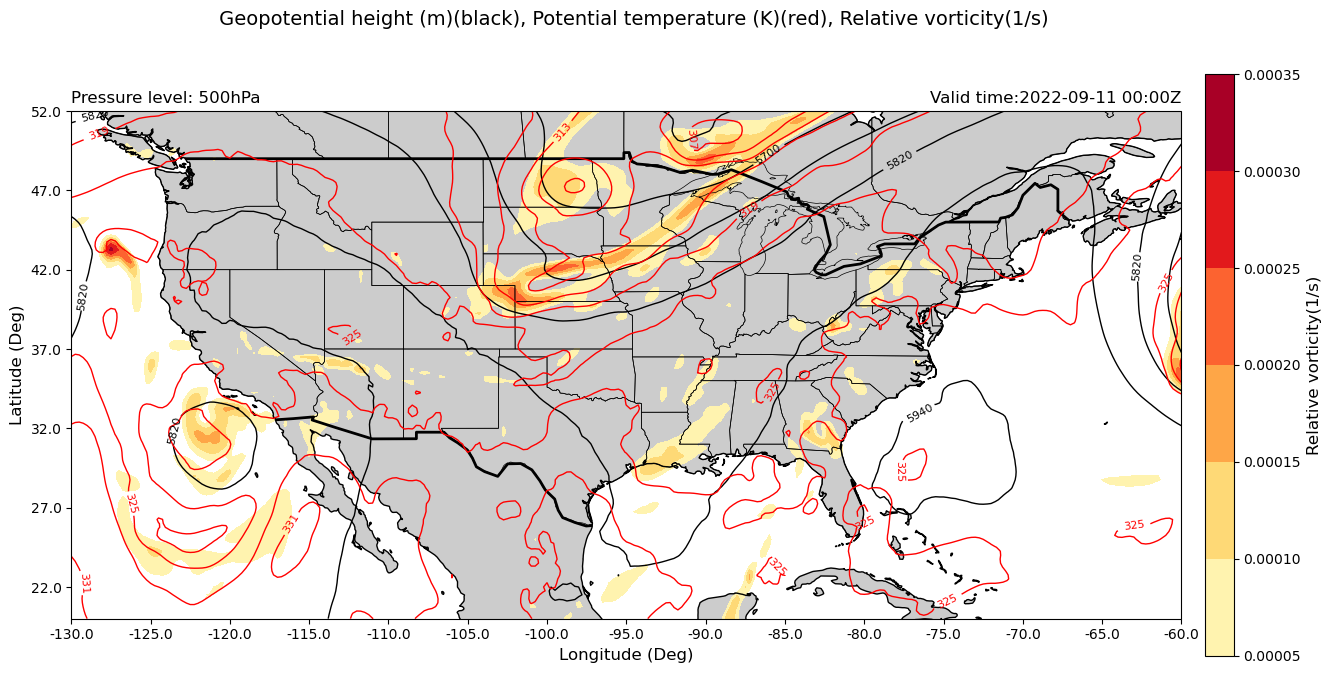

No change/Exit? [y/n]:  n
Type change: 34, -100, 45, -105, 41, -85


<Figure size 640x480 with 0 Axes>

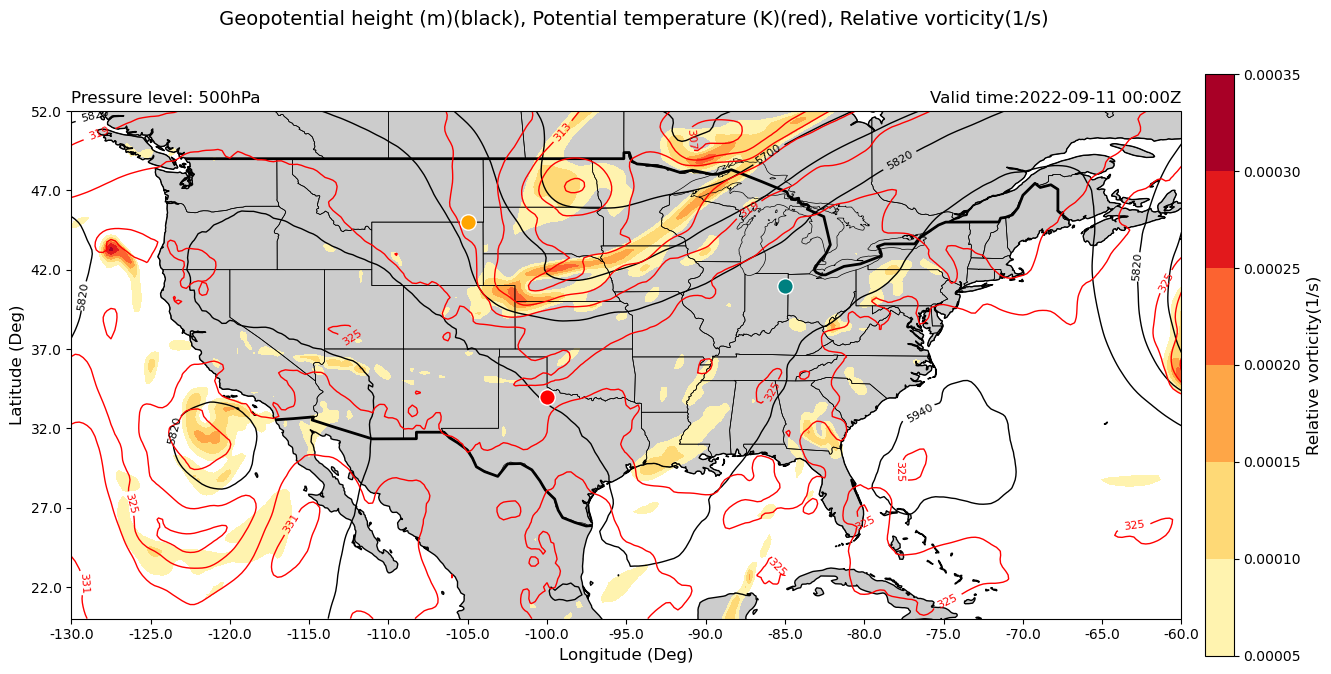

No change/Exit? [y/n]:  y


Output: [[34.0, -100.0, 45.0, -105.0], [41.0, -85.0]]


<Figure size 640x480 with 0 Axes>

In [18]:

def estimation(dataset, pos1=[None, None], pos2=[None, None], pos3=[None, None], plotfile=plotfile):
    
    r'''
    Parameters
    ----------
    dataset: 'xarray.Dataset' 
        The dataset imported before.
    pos1: 'list'
        A pair of lat, lon values in a list.
        This is the initial point!!!
    pos2: 'list'
        A pair of lat, lon values in a list.
        This is the end point of your initial crossection!!!
    pos3: 'list'
        A pair of lat, lon values in a list.
         This is the start point of the last cross section!!!
    plotfile: 'dict'
        A dictionary of plotting parameters that explained in README!
        
    Returns
    -------
    'list'
        a list of 3 critical points for the scanner. 
    '''
    
    #Base plot setting:
    fig, ax=plt.subplots(1,1, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
    
    #Parameter extraction:
    for i in list(dataset.coords):
        if i.lower() in 'latitudes':
            y=dataset[i].values
        elif i.lower() in 'longitudes':
            x=dataset[i].values
        elif i.lower() in ['pressure', 'isobaricinhpa'] or  i.lower() in 'pressure':
            z=dataset[i]
        else: 
            continue
    
    
    #Map setting:
    ax.add_feature(cfeature.LAND, facecolor='0.8')
    countries=cfeature.NaturalEarthFeature(category="cultural", scale="110m", 
                                           facecolor="none", name="admin_0_boundary_lines_land")
    ax.add_feature(countries, linewidth=2, edgecolor="black")
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
    ax.coastlines(color='k')
    
    #Part for plotting, based on the format of plotfile, the variable in the crossection can be referenced to 
    #either plotted by contourf or just contour. 
    
    title=' ' #Making initial space to the title, 
              # IMPORTANT: everytime a new variable is read, a new string is added. 
    
    #Another layer of consideration is that if the variable in crossection file is not set in the plotfile parameters, the function will not plot it.
    for key in list(dataset.keys()):
        #See if the parameter is in the 'contour catagory of the plotfile
        if key.lower() in list(plotfile['contour'].keys()): #A safety measure for matching the case between the variable name in the dataset and the plot parameters.
            rander=plotfile['contour'][key.lower()] #making all the parameters in this sub-dictionary of this plot to under one variable, so there is less length when reference later.
            #Actual plotting
            graph=ax.contour(x, y, dataset[key],      
                           levels=rander['level'], colors=rander['color'], linewidths=rander['linewidths'])
            
            #Adding label on the contour
            graph.clabel(graph.levels[1::2], fontsize=8, colors=rander['color'], inline=1,
                         inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)
            #Adding the variable to the title extracted from the pre set file.
            title+=rander['title']+'('+rander['color']+'), '

            
        #See if the parameter is in the fill catagory of the plotfile
        elif key.lower() in list(plotfile['fill'].keys()):
            rander=plotfile['fill'][key.lower()]
            #Actual plotting
            graph=ax.contourf(x, y, dataset[key],
                           levels=rander['level'], cmap=rander['cmap'])
            #We need to do a colorbar instead!
            clb=plt.colorbar(graph, orientation='vertical', ax=ax, fraction=0.025, pad=0.02)
            clb.set_label(label=rander['title'], fontsize=12) 
            
            #Adding the variable to the title extracted from the pre set file.
            title+=rander['title']+', '
            
    #Adding the suptitle, since every variable bring a comma when attached to the title string. slice out the last comma and add a space here.
    plt.suptitle(title[:-2]+' ', fontsize=14, y=0.85)
    #Adding the time, this is in datetime format!!!
    plt.title(f"Valid time:"+ str(dataset["time"].dt.strftime("%Y-%m-%d %H:%MZ").values), loc='right')
    #Adding the level
    plt.title(z.attrs['long_name'].capitalize()+' level: '
              +str(int(dataset.pressure.values))+z.attrs['units'], loc='left')
            
    #Obtaining interval for lat/lon (5 degs):
    x_int=round(5/(abs(x[0]-x[1])))
    y_int=round(5/(abs(y[0]-y[1])))
    #Set up x, y labels , ticks.
    plt.xticks(ticks=x[::x_int], labels=[str(i) for i in x[::x_int]]) 
    plt.yticks(ticks=y[::y_int], labels=[str(i) for i in y[::y_int]])
    plt.xlabel("Longitude (Deg)", fontsize=12)
    plt.ylabel("Latitude (Deg)", fontsize=12)
    
    #Marking the wanted location for crossection
    #Your initial point (pos1) in red, 
    #Your initial crossection end (pos2) in yellow, 
    #Your end of scanning (pos3) in teal
    if type(pos1[0])in [int, float] and type(pos1[1])in [int, float] :
        ax.scatter(marker='.', x=pos1[1], y=pos1[0], transform=ccrs.PlateCarree(), s=500, c='Red', edgecolors ='w',zorder=5)
    if type(pos2[0])in [int, float]  and type(pos2[1])in [int, float] :
        ax.scatter(marker='.', x=pos2[1], y=pos2[0], transform=ccrs.PlateCarree(), s=500, c='Orange', edgecolors ='w',zorder=5)
    if type(pos3[0])in [int, float]  and type(pos3[1])in [int, float] :
        ax.scatter(marker='.', x=pos3[1], y=pos3[0], transform=ccrs.PlateCarree(), s=500, c='Teal', edgecolors ='w', zorder=5)
        
    plt.show()
    
    #Confirmation
    confirm=input("No change/Exit? [y/n]: ")
    
    if confirm.lower()=='y': #You can also put a capital Y! 
        outcoord=[[pos1[0], pos1[1], pos2[0], pos2[1]], [pos3[0], pos3[1]]] #Formatting the output for future function
        
        plt.clf() 
        print("Output: "+str(outcoord))#Print out for reference if forget to assign variable
        return outcoord
    else: #Ask for new coordinate info for draw the map again.
        coord=pos1+pos2+pos3
        fix=input('Type change:').split(',')
        plt.clf() 
        #Typing the distance should be in a following format: 
        #[Start point lat,lon pair, Initial crossection end point lat, lon pair, track end point lat, lon pair]
        
        for i in range(6):
            try :
                new=float(fix[i])
            except:
                continue
            coord[i]=new

        #Deviding the typed location into paird for function to recognize 
        return estimation(dataset=dataset, pos1=coord[:2], pos2=coord[2:4], pos3=coord[4:6])
    
#Eventually, the output in in following format [[1st slice start (lat, lon), 1st slice end (lat, lon)], [last slice start (lat, lon)]]
#You can assign the output in to one variable.
output=estimation(ds1)

In [7]:
#Also check if the output is assigned!
output

[[34.0, -100.0, 45.0, -105.0], [41.0, -85.0]]

At this time, since we were choosing a certain pressure level, we need to run ```selection()``` again to get a dataset with info on <b>all pressure levels</b>.\
-You can also assign other variables to your new dataset for scanning (For example, here chooses <b>temperature</b> and <b>vertial wind</b> this time instead of geopotential height and vorticity).

In [19]:
#Do another selection (Please don't select a pressure level this time!)
ds2=selection(ds, ['t', 'thta', 'w'], extent=[-130,-60,20, 52], tidx=0)

As you can see, the output values are in a list of 2 arrays. One array is start points, and another is all end points. \
So when the scanner is actually working, it can use indexing to ascess each pair of start&end coordinates.

Finally, now is the part for actual scanning, but before that, putting the plotfile here to confirm we have all the parameter we need. 

In [25]:
###Remember, a plot can only drawn if the same variable appears on both plotfile and the dataset
plotfile={'contour':{
                 'thta':{'level': np.arange(250, 450, 3),
                         'color':'red',
                         'linewidths':1,
                         'title':"Potential temperature (K)"},
                    'z':{'level': np.arange(0, 10000, 60),
                         'color':'black',
                         'linewidths':1, 
                         'title': "Geopotential height (m)"},
                    't':{'level': np.arange(0, 400, 3),
                         'color':'black',
                         'linewidths':1, 
                         'title': "Temperature (K)"}},
             'fill':{
                   'vo':{'level': np.arange(5e-5,40e-5,5e-5),
                         'cmap':plt.cm.YlOrRd,
                         'title': "Relative vorticity(1/s)"},
                    'w':{'level': np.arange(-3.5, 3.6, 0.5),
                         'cmap':plt.cm.PuOr_r,
                         'title': "Omega(Pa/s)"}}}

Now, here is the scanner function ```scanner(slice_idx, dataset, coords_list, steps='default', plotfile=plotfile, plot=True)```, depending of the input, the scanner function has output in 3 types. \
-Video\
-Image\
-Frame for video/gif (Should just be used by function itself to make video)

Among the parameters for the function, for generating output, you must have:\
-dataset     :Your dataset to do scanning\
-coords_list :Your list of coordinates for scanning, generated from coords_generator()\
-plotfile    :As you can see when you check the function, although you must have it, you are free to use the default plotfile existing in this notebook (Just remember to name your dictionary as plotfile.

To have <b>video</b> as output, you need to do the following besides setting up above essential parameters:\
-Set slice_idx = None: (Since you are generating a video instead of an image of a specific slice of cross section.)\
-Set     plot = False: (Setting the mod for video)\
Example: ```scanner(None, ds2, coords_list, plotfile=plotfile, plot=False)```

To have <b>image</b> as output, you need to do the following besides setting up above essential parameters:\
-Set slice_idx as an integer: (indicating the index of cross section slice to be obtained)\
-Set plot = True: (This is also a default, so you can skip this part)\
Example: ```scanner(0, ds2, coords_list, plotfile=plotfile)```

Regarding the steps, that is about how many crossections images (or the number of steps) you want to get for the scanning.\
The default number of step is the magnitude in degrees plus 1 between the start and end point.\
- If you want more steps, put integers in `steps`, like ```steps=10```.

Note: The core function for finding intermidiate points is realized by [metpy.interpolate.geodesic()](https://unidata.github.io/MetPy/latest/api/generated/metpy.interpolate.geodesic.html#geodesic)

In [26]:
def scanner(slice_idx, dataset, coords, steps='default', plotfile=plotfile, plot=True):
    r'''
    Parameters
    ----------
    slice_idx: 'int' or 'None'
        The index for the cross section slices. Make video when slice = None
    
    dataset: 'xarray.Dataset'
        The dataset you use for final scanner.
    coords_list: 'list'
        A list of 2 arrays of coordinates seperated by the initial and end points for the scanner. 
        
    steps: 'str' or 'int'
        Number of points you want to take crossection between start and end. 

    plotfile: 'dict'
        A dictionary of plotting parameters that explained in README!
    plot: 'bool'
        Return a plot if True, return a video if False. 
        
    Returns
    -------
    'list'
        a list of 3 critical points for the scanner. 
    '''
    
    if type(coords[0])==list:
        #if no steps defined, the default number of step is magnitude in degrees between the start and end point.
        if steps=='default':
            steps=np.round(((coords[0][0]-coords[1][0])**2+(coords[0][1]-coords[1][1])**2)**0.5)

        #Calculate the difference between initial crossection start/end points lat&lon difference.
        difference=[coords[0][0]-coords[0][2], coords[0][1]-coords[0][3]]

        #Obtaining the crs inforamtion for geodesic() to calculate the intermidiate points
        temp_vrb=dataset.metpy.parse_cf().squeeze()[list(dataset.keys())[0]] #Need to parse inforamtion from the dataset

        cdata=temp_vrb.metpy.pyproj_crs # Obtaining info of first data array in the dataset since the .pyproj_crs works only for dataarray type.

        coord1=geodesic(cdata, coords[0][:2],  coords[1], steps=steps)#metpy.interpolate.geodesic for calculating the intermidate points. 

        #The out put is in a weird sequence ([lon, lat]) so reverse the sequence by advanced list slicing.
        coord1[:, [0,1]]=coord1[: ,[1,0]]

        #making an array for another side of the crossection by simple matrix calculation.
        coord2=coord1-difference

        coords=[coord1, coord2] #Returning start/end points in a list[start points, end points]
    else:
        pass
    
    #Clear previous plot (Especially value able when ploting for frame)
    plt.clf()
    
    #Guideing to the option of output as frame in video
    if plot==False and type(slice_idx)==int:
        global fig #Calling the global variable fig

    #Guideing to the option of output as video 
    elif plot==False and slice_idx==None:  
        fig=plt.figure(figsize=(15,10)) #Generate a figure for later function #It uses the global variable fig
        #Making animation
        ani = animation.FuncAnimation(fig, partial(scanner, dataset=dataset, coords=coords, steps=steps, plotfile=plotfile, plot=False), 
                                      repeat=False, frames=len(coords_list[0])-1, interval=200)
        video = ani.to_html5_video() 
        html = display.HTML(video)
        plt.close()
        return  display.display(html)
        
    #Guideing to the option of output as frame in plot
    elif plot==True:
        fig=plt.figure(figsize=(15,10))
        
    #Raise error of putting something weird.
    else:
        raise ValueError('Set slice_idx as a number for returning plot, None and also setting plot=False for return video')
    
    #Processing the data, parse and squeeze in order to let metpy to read related pyproj information.
    #This step is referenced by Metpy's corssection page: 
    dataset=dataset.metpy.parse_cf().squeeze()
    cross = cross_section(dataset, 
                          coords_list[1][slice_idx], 
                          coords_list[0][slice_idx]).set_coords(('lat', 'lon'))
    cross = cross.metpy.quantify()
    
    #Extractig the dimension in crossection
    
    #I think the new dimension, which is called as 'index' for indexing lat and lon value, is always behind the existing dimension, 
    #so I can utlize this feature to do an arbitrary indexing.
    x=cross[list(cross.dims.keys())[1]]
    y=cross[list(cross.dims.keys())[0]]
    
    #Adding Subplot:
    ax=fig.add_subplot(111)
    
    title=' ' #Making initial space to the title, 
              # IMPORTANT: everytime a new variable is read, a new string is added. 
    
    ###Part for plotting, based on the format of plotfile, the variable in the crossection can be referenced to 
    #either plotted by contourf or just contour. 
    
    #Another layer of consideration is that if the variable in crossection file is not set in the plotfile parameters, 
    #the function will not plot it.
    for i in list(cross.keys()):
        #See if the parameter is in the 'contour catagory of the plotfile
        if i.lower() in list(plotfile['contour'].keys()): #A safety measure for matching the case between the variable name in the dataset and the plot parameters.
            rander=plotfile['contour'][i.lower()] #making all the parameters in this sub-dictionary of this plot to under one variable, so there is less length when reference later.
            #Actual plotting
            graph=ax.contour(x, y, cross[i],      
                           levels=rander['level'], colors=rander['color'], linewidths=rander['linewidths'])
            
            #Adding label on the contour
            graph.clabel(graph.levels[1::2], fontsize=8, colors=rander['color'], inline=1,
                         inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)
            
            #Adding the variable to the title extracted from the pre set file.
            title+=rander['title']+'('+rander['color']+'), '
            
        #See if the parameter is in the fill catagory of the plotfile
        elif i.lower() in list(plotfile['fill'].keys()):
            rander=plotfile['fill'][i.lower()]
            #Actual plotting
            graph=ax.contourf(x, y, cross[i],
                           levels=rander['level'], cmap=rander['cmap'])
             #We need to do a colorbar instead!
            clb=plt.colorbar(graph, orientation='vertical', ax=ax, fraction=0.025, pad=0.02)
            clb.set_label(label=rander['title'], fontsize=12) 
            
            #Adding the variable to the title extracted from the pre set file.
            title+=rander['title']+', '
    
    
    ###Part of final annotation on labels and titles.
    
    #Annotating the start and end point 
    plt.text(-0.02, -0.04, 'Start', fontsize=14, transform=ax.transAxes)
    plt.text(0.98, -0.04, 'End', fontsize=14, transform=ax.transAxes)
    
    #If y axis is pressure, reverse the whole y axis:
    if list(cross.dims.keys())[0].lower()=='pressure':
        ax.set_ylim(y[0], y[-1])
        ax.set_yscale('symlog')
        ax.set_yticks(np.arange(1000, 50, -100))
        ax.set_yticklabels(np.arange(1000, 50, -100))
        
    #Set y axis laebls by the attributes (influding name and color).
    plt.ylabel(y.attrs['long_name'].capitalize()+" ("+y.attrs['units']+") ", fontsize=12)
    plt.xticks([]) 
        
    #Adding the sup title, since every variable bring a comma when attached to the title string. slice out the last comma and add a space here.
    plt.suptitle(title[:-2]+' ', fontsize=14)
    
    #Adding the time, this is in datetime format!!!
    plt.title(f"Valid time:"+ str(dataset["time"].dt.strftime("%Y-%m-%d %H:%MZ").values), loc='right')
    
    #Last part is to attach the start and end location
    
    #Aviod the number to be generated in sci notation:
    np.set_printoptions(suppress=True)
    
    #Merge the start and the end together
    #the resulted list looks like this: [lat1, lon1, lat2, lon2]
    ori_des=np.concatenate((np.around(coords_list[0][slice_idx], decimals=2), np.around(coords_list[1][slice_idx], decimals=2)))
    #Prepare for the final position string list for appending when all the rounded coordinates is properly convereted.
    position=[]
    
    #Doing so by the ERA5 format's lat/lon representation (North is positive for lat , east is positive for lon)
    
    for i in range(4): #I know that the coordinate can only made by 2 lat&lon pairs or 4 numbers!!!
        if i%2==0: #odd/even difference to discern wheather a lat or a lon
            if ori_des[i]>=0: 
                lat=str(ori_des[i])+" N"
            else: 
                lat=str(ori_des[i])+" S"
            position.append(lat) #Appending the string, not doing + is because the arrangement later.
        else: 
            if ori_des[i]>=0:
                lon=str(ori_des[i])+" E"
            else:
                lon=str(ori_des[i])+" W"
            position.append(lon)
    #Final arrange ment of position, explains why not simply adding the string for the stitle. 
    plt.title("From: "+position[0]+", "+position[1]+", to: "+position[2]+", "+position[3]+"", loc='Left')
    return ax

Here is an example for generating crossection at the start point.

<AxesSubplot: title={'left': 'From: 34.0 N, -100.0 W, to: 45.0 N, -105.0 W', 'right': 'Valid time:2022-09-11 00:00Z'}, ylabel='Pressure (hPa) '>

<Figure size 640x480 with 0 Axes>

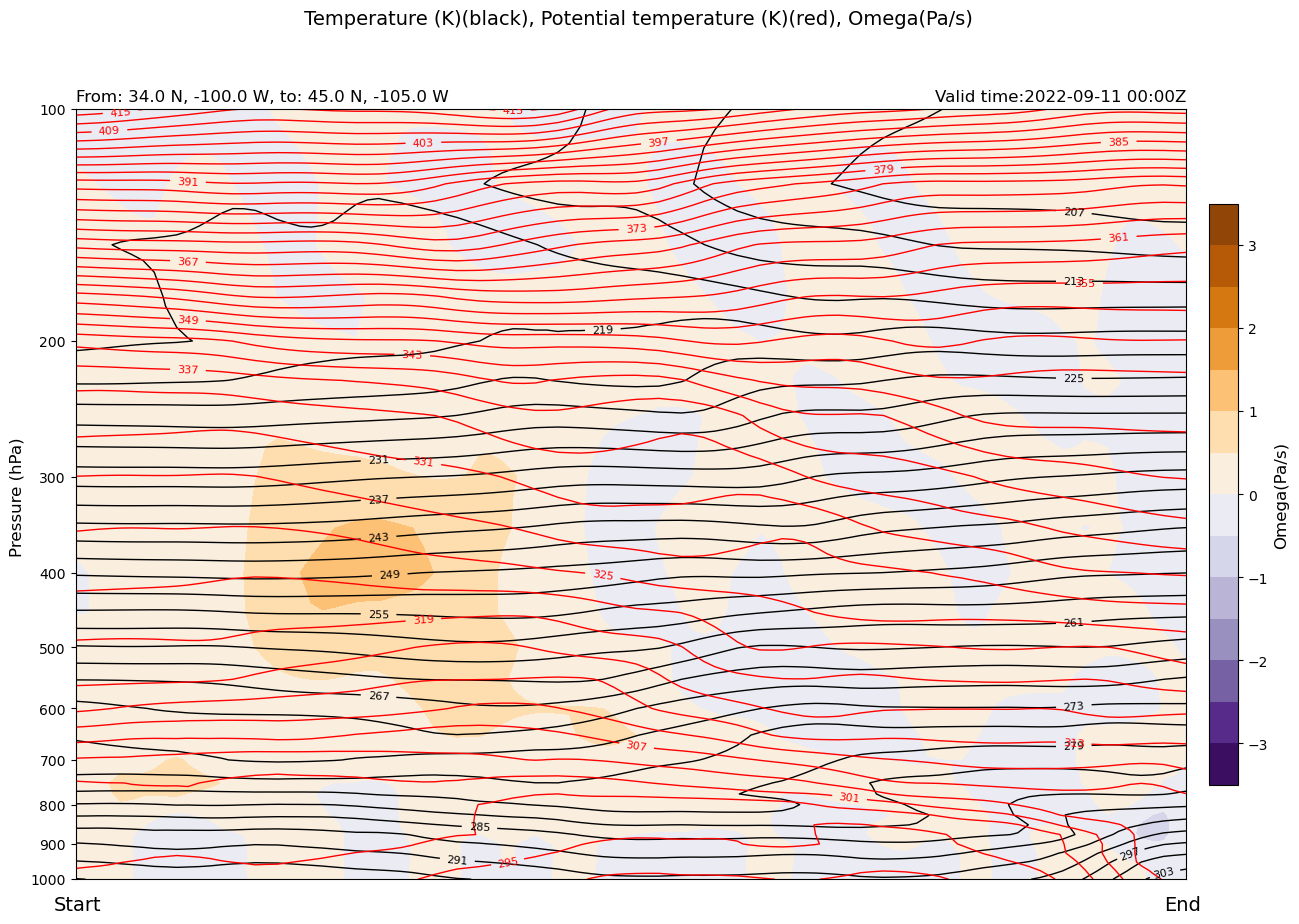

In [27]:
scanner(0, ds2, coords_list, plotfile=plotfile, plot=True)
#As it is doing indexing, you can change the index to -1 for getting the last cross section.

As one of the final goal of this notebook is to make video by the scanner function. We can change some parameters for the scanner function to run the embedded [matplotlib.animation.FuncAnimation()](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html) here.

In [23]:
#Here is an example for video (Takes a bit time)
scanner(None, ds2, coords_list, plotfile=plotfile, plot=False)

<Figure size 640x480 with 0 Axes>

### Last words
This notebook's objective is not only making cross section from example, but also creating standardized function for doing such work by any data from the [ERA5 database](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=form). However, the original vision of this notebook is even further--creating standerized functions that can take any atmospheric or oceanic .grib format data to do cross section scanning. I still want this to be my half way goal--as all of these functions are planned to be in a module that can do atmospheric and oceanolograph scanning in different perspectives (Virtical Crossection, Horizontal Elevation, and Time lapse of a given layer and location), and eventually use for generating plots for my future research and my personal website.